# Off-Axis Propagation

Below we see how to propagate off-axis, namely shift the destination plane as in [this paper](https://opg.optica.org/oe/fulltext.cfm?uri=oe-18-17-18453&id=205150).
This can reduce the FFT size if one is interested in the field off-axis, instead of having to propagate large fields.

Let's create a rectangular aperture at the input.

Field shape [um]:  1089.536
Width of aperture [um]:  544.768
Propagation distance [um]:  108953.6


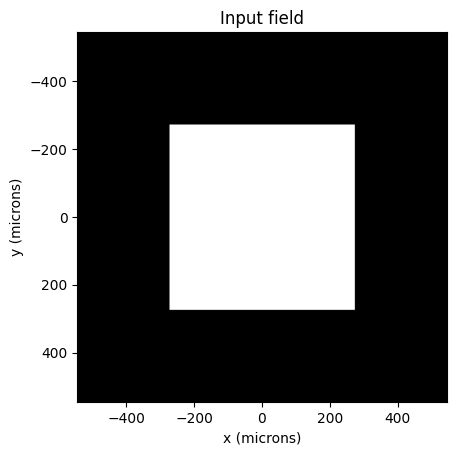

In [1]:
from functools import partial

import matplotlib.pyplot as plt

import chromatix.functional as cf
from chromatix import shift_grid

shape = (1024, 1024)
pad_width = (512, 512)  # padding to linearize the FFT
spectrum = 0.532  # wavelength
dxi = 2 * spectrum
D = dxi * shape[0]  # field shape
w = D / 2  # width of aperture
z = 100 * D  # propagation distance
spacing = dxi
n = 1  # refractive index of medium

print("Field shape [um]: ", D)
print("Width of aperture [um]: ", w)
print("Propagation distance [um]: ", z)

field = cf.plane_wave(
    shape=shape,
    dx=spacing,
    spectrum=spectrum,
    pupil=partial(cf.square_pupil, w=w),
)
plt.imshow(
    field.amplitude.squeeze(),
    cmap="gray",
    extent=[
        -D / 2,
        D / 2,  # x-axis
        D / 2,
        -D / 2,
    ],  # y-axis
)
plt.title("Input field")
plt.ylabel("y (microns)")
plt.xlabel("x (microns)");

By default, a field is centered at the origin but we can shift the field.

Original spatial limits (y, x):  [(-544, 543), (-544, 543)]
Shifted spatial limits  (y, x):  [(-544, 543), (0, 1088)]


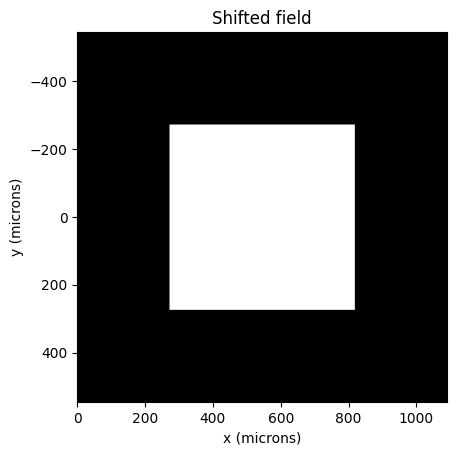

In [2]:
shift_yx = (0, D / 2)  # along x-axis
# shift_yx = (D / 2, 0)  # along y-axis
extent = [  # for plotting
    -D / 2 + shift_yx[1],
    D / 2 + shift_yx[1],
    D / 2 + shift_yx[0],
    -D / 2 + shift_yx[0],
]
shifted_field = shift_grid(field, shift_yx=shift_yx)
# print rounded spatial limits
print(
    "Original spatial limits (y, x): ",
    [(int(x[0]), int(x[1])) for x in field.spatial_limits],
)
print(
    "Shifted spatial limits  (y, x): ",
    [(int(x[0]), int(x[1])) for x in shifted_field.spatial_limits],
)

plt.imshow(field.amplitude.squeeze(), cmap="gray", extent=extent)
plt.title("Shifted field")
plt.ylabel("y (microns)")
plt.xlabel("x (microns)");

Below we show how to propagate a field off-axis. 

Usually this will be done on a centered field, i.e. as `field` above.

Let's first propagate without shifting the destination plane.

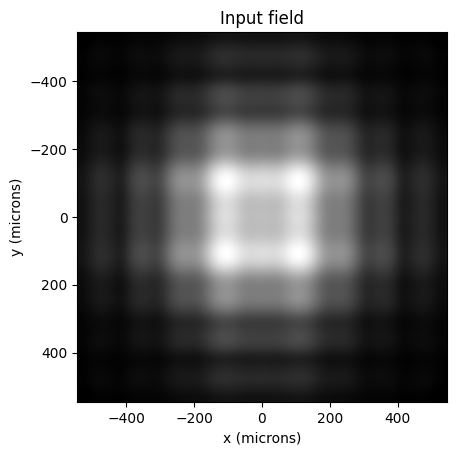

In [3]:
# Bandlimited angular spectrum
out_field_blas = cf.asm_propagate(
    field, z, n, pad_width=pad_width, mode="same", bandlimit=True
)

plt.imshow(
    out_field_blas.amplitude.squeeze(),
    cmap="gray",
    extent=[
        -D / 2,
        D / 2,  # x-axis
        D / 2,
        -D / 2,
    ],  # y-axis
)
plt.title("Input field")
plt.ylabel("y (microns)")
plt.xlabel("x (microns)");

Let's shift by half the aperture width along the x-axis. We compare with adjusting the kernel (as in [this paper](https://opg.optica.org/oe/fulltext.cfm?uri=oe-18-17-18453&id=205150)) and using the chirp Z-transform (CZT).

By default `use_czt` is set `False` in this case, as using it is slower than the method mentioned in the above paper.

Avg time for BLAS with adjusted kernel:  0.026149487495422362
Avg time for BLAS with CZT:  0.06822526454925537


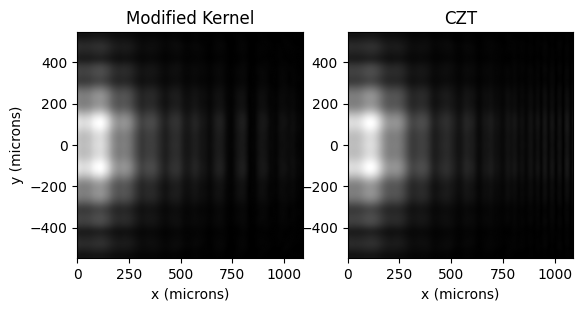

In [4]:
import time

n_trials = 10

shift_yx = (0, D / 2)

extent = [  # for plotting
    -D / 2 + shift_yx[1],
    D / 2 + shift_yx[1],
    -D / 2 + shift_yx[0],
    D / 2 + shift_yx[0],
]

# Angular spectrum (bandlimited with adjust kernel)
shifted_field = cf.asm_propagate(
    field,
    z,
    n,
    pad_width=pad_width,
    mode="same",
    bandlimit=True,
    shift_yx=shift_yx,
)
start_time = time.time()
for _ in range(n_trials):
    shifted_field = cf.asm_propagate(
        field,
        z,
        n,
        pad_width=pad_width,
        mode="same",
        bandlimit=True,
        shift_yx=shift_yx,
    )
print("Avg time for BLAS with adjusted kernel: ", (time.time() - start_time) / n_trials)
u_asm = shifted_field.amplitude.squeeze()

# Angular spectrum (bandlimited CZT) - takes longer due to CZT
shifted_field_czt = cf.asm_propagate(
    field,
    z,
    n,
    pad_width=pad_width,
    mode="same",
    bandlimit=True,
    shift_yx=shift_yx,
    # set spacing to force usage of CZT
    output_dx=field.dx,
    use_czt=True,
)
start_time = time.time()
for _ in range(n_trials):
    shifted_field_czt = cf.asm_propagate(
        field,
        z,
        n,
        pad_width=pad_width,
        mode="same",
        bandlimit=True,
        shift_yx=shift_yx,
        output_dx=field.dx,
        use_czt=True,
    )
print("Avg time for BLAS with CZT: ", (time.time() - start_time) / n_trials)
u_czt = shifted_field_czt.amplitude.squeeze()

# plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(u_asm, cmap="gray", extent=extent)
axs[0].set_title("Modified Kernel")
axs[0].set_ylabel("y (microns)")
axs[0].set_xlabel("x (microns)")
axs[1].imshow(u_czt, cmap="gray", extent=extent)
axs[1].set_title("CZT")
axs[1].set_xlabel("x (microns)");

Using CZT takes longer as it requires more FFTs.

Let's tilt the illumination and shift off-axis (without CZT).

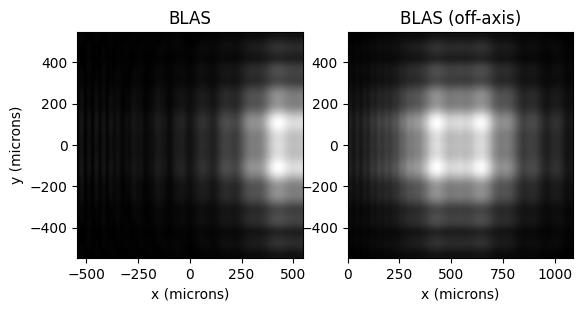

In [5]:
# -- tilt and shift in x
kykx = (0, -5 / w)
shift_yx = (0, D / 2)
# # -- tilt and shift in y
# kykx = (-5 / w, 0)
# shift_yx = (D / 2, 0)
extent = [  # for plotting
    -D / 2,
    D / 2,
    -D / 2,
    D / 2,
]
extent_shifted = [  # for plotting
    -D / 2 + shift_yx[1],
    D / 2 + shift_yx[1],
    -D / 2 + shift_yx[0],
    D / 2 + shift_yx[0],
]

# Angular spectrum
out_blas = cf.asm_propagate(
    field, z, n, pad_width=pad_width, mode="same", bandlimit=True, kykx=kykx
)

# Angular spectrum (shifted)
out_blas_off_axis = cf.asm_propagate(
    field,
    z,
    n,
    pad_width=pad_width,
    mode="same",
    bandlimit=True,
    shift_yx=shift_yx,
    kykx=kykx,
)

# plot
fig, axs = plt.subplots(1, 2)
axs[0].imshow(out_blas.amplitude.squeeze(), cmap="gray", extent=extent)
axs[0].set_title("BLAS")
axs[0].set_ylabel("y (microns)")
axs[0].set_xlabel("x (microns)")
axs[1].imshow(out_blas_off_axis.amplitude.squeeze(), cmap="gray", extent=extent_shifted)
axs[1].set_title("BLAS (off-axis)")
axs[1].set_xlabel("x (microns)");